[Оригинальный notebook](https://www.kaggle.com/code/sharthz23/implicit-lightfm/notebook)

In [1]:
from collections import defaultdict
import os
import datetime

import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender
from implicit.als import AlternatingLeastSquares
from implicit import gpu
from lightfm.data import Dataset
from lightfm import LightFM
import polars as pl

Implicit ALS с GPU:

In [2]:
gpu.HAS_CUDA

True

In [3]:
sns.set_style("darkgrid")

In [4]:
%load_ext autoreload
%autoreload 2

from recs_utils.metrics import compute_metrics, model_cross_validate
from recs_utils.load_data import load_users, load_items, load_interactions, sample_true_rec_data
from recs_utils.simple_rec import PopularRecommender, PopularRecommenderPerAge
from recs_utils.split import train_test_split, TimeRangeSplit
from recs_utils.matrix_ops import interactions_to_csr_matrix
from recs_utils.implicit_model import ImplicitRecommender, LightFMRecommender
from recs_utils.utils import get_direct_and_inv_mapping

# Подготовка данных

In [5]:
data_dir = "data"

In [6]:
df = load_interactions(os.path.join(data_dir, "interactions.csv"))
df_users = load_users(os.path.join(data_dir, "users.csv"))
df_items = load_items(os.path.join(data_dir, "items.csv"))

In [7]:
df_items.head()

item_id,title,genres,authors,year
u32,str,cat,cat,cat
128115,"""Ворон-челобитч…","""Зарубежные дет…","""Михаил Салтыко…","""1886"""
210979,"""Скрипка Ротшил…","""Классическая п…","""Антон Чехов""","""1894"""
95632,"""Испорченные де…","""Зарубежная кла…","""Михаил Салтыко…","""1869"""
247906,"""Странный челов…","""Пьесы и драмат…","""Михаил Лермонт…","""1831"""
294280,"""Господа ташкен…","""Зарубежная кла…","""Михаил Салтыко…","""1873"""


In [8]:
users_mapping, users_inv_mapping = get_direct_and_inv_mapping(df, "user_id")
len(users_mapping)

151600

In [9]:
items_mapping, items_inv_mapping = get_direct_and_inv_mapping(df, "item_id")
len(items_mapping)

59599

In [10]:
df_items = df_items.with_columns(pl.col("title").str.strip().str.to_lowercase().alias("title"))

In [11]:
item_titles = {item_info["item_id"]: item_info["title"] for item_info in df_items.select(pl.col("item_id"), pl.col("title")).unique().to_dicts()}

In [12]:
len(item_titles), item_titles[128115]

(59599, 'ворон-челобитчик')

In [13]:
df_items.head()

item_id,title,genres,authors,year
u32,str,cat,cat,cat
128115,"""ворон-челобитч…","""Зарубежные дет…","""Михаил Салтыко…","""1886"""
210979,"""скрипка ротшил…","""Классическая п…","""Антон Чехов""","""1894"""
95632,"""испорченные де…","""Зарубежная кла…","""Михаил Салтыко…","""1869"""
247906,"""странный челов…","""Пьесы и драмат…","""Михаил Лермонт…","""1831"""
294280,"""господа ташкен…","""Зарубежная кла…","""Михаил Салтыко…","""1873"""


In [14]:
title_items = df_items.sort("title").select(
    pl.col("title"),
    pl.col("item_id").implode().over("title"),
    pl.count().over("title")
).unique("title", maintain_order=True)

In [15]:
title_items.head(n=4)

title,item_id,count
str,list[u32],u32
"""# 20 восьмая""",[201623],1
"""# duo""",[72582],1
"""# me too. рома…",[171172],1
"""# партия""",[224512],1


In [16]:
title_items.select(pl.col("count").value_counts(sort=True))

count
struct[2]
"{1,55708}"
"{2,1197}"
"{3,245}"
"{4,71}"
"{5,38}"
"{6,11}"
"{7,8}"
"{8,3}"
"{9,2}"


In [17]:
title_items.filter(pl.col("count") > 1).tail()

title,item_id,count
str,list[u32],u32
"""яма""","[60156, 165785]",2
"""янки из коннек…","[14759, 56530]",2
"""японская диета…","[168986, 74652]",2
"""яр""","[168761, 5371]",2
"""ящик пандоры""","[236465, 158851]",2


In [18]:
df_items.filter(pl.col("title") == "ящик пандоры")

item_id,title,genres,authors,year
u32,str,cat,cat,cat
236465,"""ящик пандоры""","""Любовно-фантас…","""Филипп Хорват""","""2017"""
158851,"""ящик пандоры""","""Мистика,Соврем…","""Бернар Вербер""","""2018"""


In [19]:
title_items.filter(pl.col("count") > 1).head()

title,item_id,count
str,list[u32],u32
"""(о переводе)""","[61213, 145263]",2
"""2084""","[177082, 281410]",2
"""451 градус по …","[44681, 162716]",2
"""playboy 02-201…","[114405, 8599]",2
"""playboy 03-201…","[31097, 121747]",2


In [20]:
df_items.filter(pl.col("title") == "451 градус по фаренгейту")

item_id,title,genres,authors,year
u32,str,cat,cat,cat
44681,"""451 градус по …","""Социальная фан…","""Рэй Брэдбери""","""1953"""
162716,"""451 градус по …","""Социальная фан…","""Рэй Брэдбери""","""1951, 1953, 19…"


In [21]:
df.head(n=3)

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
126706,14433,80,NaN,2018-01-01
127290,140952,58,NaN,2018-01-01
66991,198453,89,NaN,2018-01-01


In [22]:
df.lazy().filter(pl.col("item_id").is_in([44681, 162716])).fill_nan(None).groupby("item_id").agg(
    [
        pl.count("progress"),
        pl.col("rating").min().alias("min_rating"),
        pl.col("rating").mean().alias("mean_rating"),
        pl.col("rating").max().alias("max_rating"),
        pl.col("start_date").min().alias("min_start_date"),
        pl.col("start_date").max().alias("max_start_date")
    ]
).collect()

item_id,progress,min_rating,mean_rating,max_rating,min_start_date,max_start_date
u32,u32,f32,f32,f32,date,date
44681,353,1.0,4.56,5.0,2018-01-24,2019-12-20
162716,59,4.0,4.8,5.0,2018-01-25,2019-12-30


In [23]:
last_date = df.select(pl.col("start_date").max())[0, 0]

In [24]:
folds = 7
start_date = last_date - datetime.timedelta(days=folds)
start_date, last_date

(datetime.date(2019, 12, 24), datetime.date(2019, 12, 31))

In [25]:
cv = TimeRangeSplit(start_date=start_date, interval=datetime.timedelta(days=1), folds=folds)

cv.max_n_splits, cv.get_n_splits(df, datetime_column='start_date')

(7, 7)

In [26]:
cv.date_range[1:]

date_col
date
2019-12-25
2019-12-26
2019-12-27
2019-12-28
2019-12-29
2019-12-30
2019-12-31


In [27]:
folds_with_stats = list(cv.split(
    df, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='start_date',
    fold_stats=True
)
)

folds_info_with_stats = pl.DataFrame([info for _, _, info in folds_with_stats])

In [28]:
folds_info_with_stats

Start date,End date,Train,New users,New users interactions,New items,New items interactions,Known interactions,Test
date,date,i64,i64,i64,i64,i64,i64,i64
2019-12-24,2019-12-25,1515946,3,3,0,0,0,2045
2019-12-25,2019-12-26,1517994,1,1,0,0,0,2141
2019-12-26,2019-12-27,1520136,0,0,0,0,0,2177
2019-12-27,2019-12-28,1522313,0,0,0,0,0,2110
2019-12-28,2019-12-29,1524423,2,4,0,0,0,2205
2019-12-29,2019-12-30,1526632,4,4,0,0,0,2118
2019-12-30,2019-12-31,1528754,1,1,0,0,0,2168


In [29]:
top_N = 10

# Implicit

In [30]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.join(train_idx, on=["user_id", "item_id"], how="inner")
test = df.join(test_idx, on=["user_id", "item_id"], how="inner")
train.shape, test.shape

((1515946, 5), (2045, 5))

In [31]:
cosine_model = ImplicitRecommender(CosineRecommender(K=10), users_mapping, items_mapping, items_inv_mapping)

In [32]:
cosine_model.fit(train)

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008853673934936523 seconds
  warnings.warn(


  0%|          | 0/59599 [00:00<?, ?it/s]

In [33]:
user_id = test.select(pl.col("user_id"))[0, 0]
print(f'Рекомендации для пользователя {user_id}')

Рекомендации для пользователя 139942


In [34]:
pred_recs = cosine_model.recommend([user_id], n=top_N)

In [35]:
pred_recs

user_id,item_id,rank
u32,u32,u32
139942,193358,1
139942,125586,2
139942,203882,3
139942,90986,4
139942,146180,5
139942,264849,6
139942,238155,7
139942,7094,8
139942,240226,9


In [36]:
test.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
139942,26270,58,NaN,2019-12-24
136607,82392,39,NaN,2019-12-24
142287,84446,79,NaN,2019-12-24
114933,319155,9,NaN,2019-12-24
32926,120339,73,NaN,2019-12-24


In [37]:
pred_recs = cosine_model.recommend(test.select(pl.col("user_id").unique()).to_series(), n=top_N)

In [38]:
pred_recs

user_id,item_id,rank
u32,u32,u32
27,205779,1
27,270698,2
27,300693,3
27,44437,4
27,128993,5
27,251031,6
27,261532,7
27,305853,8
27,57696,9


In [39]:
pred_recs.head(top_N + 3)

user_id,item_id,rank
u32,u32,u32
27,205779,1
27,270698,2
27,300693,3
27,44437,4
27,128993,5
27,251031,6
27,261532,7
27,305853,8
27,57696,9


In [40]:
pred_recs.filter(pl.col("user_id") == 139942).head(top_N + 3)

user_id,item_id,rank
u32,u32,u32
139942,193358,1
139942,125586,2
139942,203882,3
139942,90986,4
139942,146180,5
139942,264849,6
139942,238155,7
139942,7094,8
139942,240226,9


In [41]:
test.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
139942,26270,58,NaN,2019-12-24
136607,82392,39,NaN,2019-12-24
142287,84446,79,NaN,2019-12-24
114933,319155,9,NaN,2019-12-24
32926,120339,73,NaN,2019-12-24


In [42]:
metrics = compute_metrics(test, pred_recs, top_N)

In [43]:
metrics

name,value
str,f64
"""prec@1""",0.011628
"""recall@1""",0.011628
"""prec@2""",0.010098
"""recall@2""",0.010098
"""prec@3""",0.00918
"""recall@3""",0.00918
"""prec@4""",0.007956
"""recall@4""",0.007956
"""prec@5""",0.007222


In [44]:
def create_cosine_model():
    return ImplicitRecommender(CosineRecommender(K=top_N), users_mapping, items_mapping, items_inv_mapping)


def create_bm25():
    return ImplicitRecommender(BM25Recommender(K=top_N), users_mapping, items_mapping, items_inv_mapping)

def create_tfidf():
    return ImplicitRecommender(TFIDFRecommender(K=top_N), users_mapping, items_mapping, items_inv_mapping)

def create_alsm():
    return ImplicitRecommender(AlternatingLeastSquares(factors=32, iterations=10), users_mapping, items_mapping, items_inv_mapping)

In [45]:
cv_res_per_model = []
models = {}

In [46]:
for factory in (create_cosine_model, create_bm25, create_tfidf, create_alsm):
    cross_valid_res_model, model = model_cross_validate(
        df, 
        user_features=df_users, 
        item_features=df_items, 
        folds=folds_with_stats, 
        model_factory=factory, 
        n=top_N)
    models[model.model_name()] = model
    cv_res_per_model.append(cross_valid_res_model.to_pandas())
    del cross_valid_res_model

  0%|          | 0/7 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00917196273803711 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008222579956054688 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00911569595336914 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009116172790527344 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/imp

  0%|          | 0/7 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00940704345703125 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009647369384765625 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.012760162353515625 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0091705322265625 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/impl

  0%|          | 0/7 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00896596908569336 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009010553359985352 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.011895895004272461 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008475780487060547 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/im

  0%|          | 0/7 [00:00<?, ?it/s]

In [47]:
cross_valid_res = pd.concat(cv_res_per_model)
cv_res_per_model.clear()

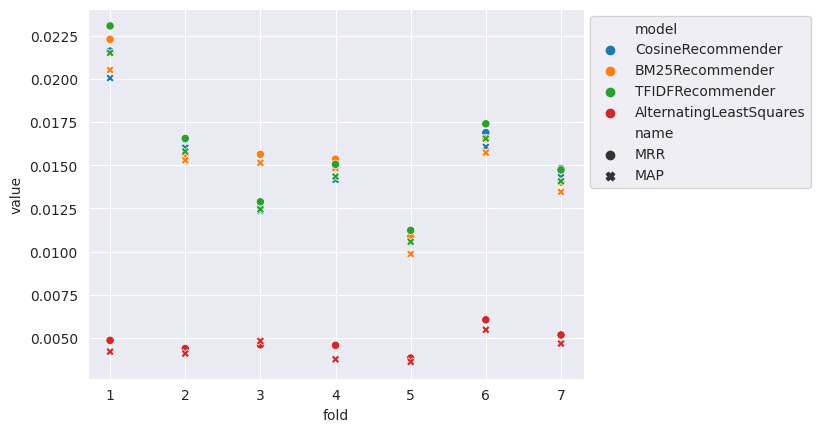

In [48]:
ax = sns.scatterplot(cross_valid_res[cross_valid_res["name"].isin(["MAP", "MRR"])], x="fold", y="value", style="name", hue="model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [49]:
cross_valid_res.pivot(index=["fold", "model"], columns=["name"], values=["value"]).droplevel(level=0, axis="columns").groupby("model").agg(
    {
    "MRR": ['mean', 'std', 'min', 'max'],
    'MAP': ['mean', 'std', 'min', 'max'],
    f'recall@{top_N}': ['mean', 'std', 'min', 'max'],
    }
)

name                          MRR                                     MAP   
                             mean       std       min       max      mean   
model                                                                       
AlternatingLeastSquares  0.004777  0.000695  0.003831  0.006044  0.004372  \
BM25Recommender          0.015759  0.003429  0.010862  0.022296  0.014975   
CosineRecommender        0.015503  0.003368  0.011206  0.021611  0.014784   
TFIDFRecommender         0.015844  0.003811  0.011226  0.023071  0.015038   

name                                                  recall@10             
                              std       min       max      mean       std   
model                                                                       
AlternatingLeastSquares  0.000654  0.003605  0.005469  0.001427  0.000215  \
BM25Recommender          0.003163  0.009854  0.020521  0.003588  0.000606   
CosineRecommender        0.003035  0.010556  0.020050  0.003562  0.000772   
TFIDFRecommender         0.003484  0.010563  0.021505  0.003622  0.000650   

name                                         
                              min       max  
model                                        
AlternatingLeastSquares  0.001265  0.001890  
BM25Recommender          0.003078  0.004774  
CosineRecommender        0.002873  0.004896  
TFIDFRecommender         0.002998  0.004712

In [50]:
models.keys()

dict_keys(['CosineRecommender', 'BM25Recommender', 'TFIDFRecommender', 'AlternatingLeastSquares'])

In [51]:
similiar_items = models["TFIDFRecommender"].similiar_items([60193], top_N)

In [52]:
similiar_items = similiar_items.with_columns(
    pl.col("item_id").apply(item_titles.get).alias("orig_titles"),
    pl.col("similiar_item_id").apply(item_titles.get).alias("sim_titles")
    )

In [53]:
similiar_items

item_id,similiar_item_id,score,orig_titles,sim_titles
u32,u32,f32,str,str
60193,60193,1.0,"""мастер и марга…","""мастер и марга…"
60193,252228,0.085901,"""мастер и марга…","""мастер и марга…"
60193,283431,0.057461,"""мастер и марга…","""мастер и марга…"
60193,106146,0.038287,"""мастер и марга…","""без имени"""
60193,129959,0.034565,"""мастер и марга…","""белая гвардия.…"
60193,229856,0.033712,"""мастер и марга…","""булгаков и «ма…"
60193,284757,0.033223,"""мастер и марга…","""стори 11-2015"""
60193,214968,0.03252,"""мастер и марга…","""драгоценная пл…"
60193,303726,0.031764,"""мастер и марга…","""ничего не возь…"


# LightFM

In [54]:
dataset = Dataset()

In [55]:
dataset.fit(df.select(pl.col("user_id")).unique().to_series(), df.select(pl.col("item_id")).unique().to_series())

In [56]:
lfm_df_users = df_users.clone()
lfm_df_items = df_items.clone()

In [57]:
lfm_df_users = lfm_df_users.with_columns(
    pl.col("age").cast(str).fill_null("age_unknown").cast(pl.Categorical).alias("age"),
    pl.col("sex").cast(str).fill_null("sex_unknown").cast(pl.Categorical).alias("sex")
)

In [58]:
lfm_df_users.select(pl.col("sex").unique())

sex
cat
"""sex_unknown"""
"""0.0"""
"""1.0"""


In [59]:
lfm_df_users.select(pl.col("age").unique())

age
cat
"""45_54"""
"""18_24"""
"""65_inf"""
"""35_44"""
"""55_64"""
"""25_34"""
"""age_unknown"""


In [60]:
age_features = lfm_df_users.select(pl.col("age").unique()).to_series().to_list()
sex_features = lfm_df_users.select(pl.col("sex").unique()).to_series().to_list()

In [61]:
users_features = age_features + sex_features
users_features

['45_54',
 '18_24',
 '65_inf',
 '35_44',
 '55_64',
 '25_34',
 'age_unknown',
 'sex_unknown',
 '0.0',
 '1.0']

In [62]:
dataset.fit_partial(user_features=users_features)

In [63]:
lfm_df_items = lfm_df_items.with_columns(
    pl.col("genres").cast(str).fill_null("genre_unknown").cast(pl.Categorical).alias("genres")
)

In [64]:
genres = lfm_df_items.select(pl.col("genres").cast(str).str.split(',').explode().unique()).to_series().to_list()
len(genres)

641

In [65]:
dataset.fit_partial(item_features=genres)

In [66]:
num_users, num_items = dataset.interactions_shape()
num_users, num_items

(151600, 59599)

In [67]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('users_mapping len - ', len(lightfm_mapping['users_mapping']))
print('user_features_mapping len - ', len(lightfm_mapping['user_features_mapping']))
print('items_mapping len - ', len(lightfm_mapping['items_mapping']))
print('Users item_features_mapping len - ', len(lightfm_mapping['item_features_mapping']))

users_mapping len -  151600
user_features_mapping len -  151610
items_mapping len -  59599
Users item_features_mapping len -  60240


In [68]:
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [69]:
num_user_features = dataset.user_features_shape()
num_show_features = dataset.item_features_shape()
print('Num user features: {} -> {}\nnum item features: {} -> {}.'.format(
    num_user_features[1] - num_users, num_user_features[1], 
    num_show_features[1] - num_items, num_show_features[1]))

Num user features: 10 -> 151610
num item features: 641 -> 60240.


In [70]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.join(train_idx, on=["user_id", "item_id"], how="inner")
test = df.join(test_idx, on=["user_id", "item_id"], how="inner")

In [71]:
train_mat, train_mat_weights = dataset.build_interactions(train.select(
    pl.col("user_id"),
    pl.col("item_id")
).to_numpy()
)
train_mat

<151600x59599 sparse matrix of type '<class 'numpy.int32'>'
	with 1515946 stored elements in COOrdinate format>

In [72]:
train_mat_weights

<151600x59599 sparse matrix of type '<class 'numpy.float32'>'
	with 1515946 stored elements in COOrdinate format>

In [73]:
lfm_df_users = lfm_df_users.with_columns(
    pl.concat_list(pl.col("age").cast(str), pl.col("sex").cast(str)).alias("features")
)

In [74]:
lfm_df_users.head()

user_id,age,sex,features
u32,cat,cat,list[str]
1,"""45_54""","""sex_unknown""","[""45_54"", ""sex_unknown""]"
2,"""18_24""","""0.0""","[""18_24"", ""0.0""]"
3,"""65_inf""","""0.0""","[""65_inf"", ""0.0""]"
4,"""18_24""","""0.0""","[""18_24"", ""0.0""]"
5,"""35_44""","""0.0""","[""35_44"", ""0.0""]"


In [75]:
def to_light_fm_feature(row_info: dict, entity_key: str):
    return (row_info[entity_key], row_info["features"])

In [76]:
known_users_mask = lfm_df_users.select(pl.col("user_id").is_in(df.select(pl.col("user_id").unique()).to_series())).to_series()

train_user_features = dataset.build_user_features(
    map(lambda x: to_light_fm_feature(x, "user_id"), lfm_df_users.filter(known_users_mask).select(pl.col("user_id"), pl.col('features')).to_dicts())
)

train_user_features

<151600x151610 sparse matrix of type '<class 'numpy.float32'>'
	with 422954 stored elements in Compressed Sparse Row format>

In [77]:
lfm_df_items = lfm_df_items.with_columns(
    pl.col("genres").cast(str).str.split(",").alias("features")
)

In [78]:
lfm_df_items.head()

item_id,title,genres,authors,year,features
u32,str,cat,cat,cat,list[str]
128115,"""ворон-челобитч…","""Зарубежные дет…","""Михаил Салтыко…","""1886""","[""Зарубежные детские книги"", ""Сказки"", … ""Русская классика""]"
210979,"""скрипка ротшил…","""Классическая п…","""Антон Чехов""","""1894""","[""Классическая проза"", ""Литература 19 века"", ""Русская классика""]"
95632,"""испорченные де…","""Зарубежная кла…","""Михаил Салтыко…","""1869""","[""Зарубежная классика"", ""Классическая проза"", … ""Русская классика""]"
247906,"""странный челов…","""Пьесы и драмат…","""Михаил Лермонт…","""1831""","[""Пьесы и драматургия"", ""Литература 19 века""]"
294280,"""господа ташкен…","""Зарубежная кла…","""Михаил Салтыко…","""1873""","[""Зарубежная классика"", ""Классическая проза"", … ""Русская классика""]"


In [79]:
lfm_df_items.select(
    pl.col("features").apply(len).value_counts(sort=True)
)

features
struct[2]
"{2,20734}"
"{1,20172}"
"{3,12699}"
"{4,4248}"
"{5,1074}"
"{6,373}"
"{7,146}"
"{8,74}"
"{9,34}"


In [80]:
known_items_mask = lfm_df_items.select(pl.col("item_id").is_in(df.select("item_id").unique().to_series())).to_series()

train_items_features = dataset.build_item_features(
        map(lambda x: to_light_fm_feature(x, "item_id"), lfm_df_items.filter(known_items_mask).select(
    pl.col("item_id"),
    pl.col("features")
        ).to_dicts())
)
train_items_features

<59599x60240 sparse matrix of type '<class 'numpy.float32'>'
	with 186360 stored elements in Compressed Sparse Row format>

In [81]:
lfm_model = LightFM(no_components=64, learning_rate=0.05, loss='warp', max_sampled=5, random_state=23)

In [82]:
num_epochs = 5

for _ in trange(num_epochs):
    lfm_model.fit_partial(
        train_mat, 
        user_features=train_user_features,
        item_features=train_items_features,
        num_threads=4
    )

  0%|          | 0/5 [00:00<?, ?it/s]

In [83]:
user_id = test.filter(pl.col("user_id") == 139942).select(pl.col("user_id"))[0, 0]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Рекомендации для пользователя {user_id}, номер строки - {row_id}')

Рекомендации для пользователя 139942, номер строки - 118624


In [84]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

59599

In [85]:
pred = lfm_model.predict(row_id, all_cols, user_features=train_user_features, item_features=train_items_features)
pred, pred.shape

(array([-102.696304, -104.030266, -102.655075, ..., -103.08725 ,
        -101.69688 , -102.9859  ], dtype=float32),
 (59599,))

In [86]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([40476,  8982, 44037, 23361, 57867, 54292,  2905, 30751,  3270,
       28360])

In [87]:
pred[top_cols]

array([-98.44744 , -98.76437 , -98.76509 , -98.98874 , -98.99312 ,
       -99.02999 , -99.0353  , -99.06246 , -99.06981 , -99.072296],
      dtype=float32)

In [88]:
pred.max()

-98.44744

In [89]:
recs = pl.DataFrame(
    {"col_id": top_cols,
     "item_id": list(map(lightfm_mapping['items_inv_mapping'].get, top_cols))
    },
    schema={"col_id": test.schema["item_id"], "item_id": test.schema["item_id"]}
)
recs = recs.with_columns(pl.col("item_id").apply(item_titles.get).alias("title"))
recs

col_id,item_id,title
u32,u32,str
40476,99357,"""сила подсознан…"
8982,211217,"""ни сы. восточн…"
44037,281005,"""богатый папа, …"
23361,155451,"""выйди из зоны …"
57867,90519,"""думай медленно…"
54292,24551,"""магическая убо…"
2905,89152,"""50 правил умно…"
30751,159580,"""пятьдесят отте…"
3270,310952,"""вы ничего не з…"


In [90]:
def create_lightfm():
    return LightFMRecommender(
        LightFM(
            no_components=64, 
            learning_rate=0.05, 
            loss='warp', 
            max_sampled=5, 
            random_state=23),
             num_epoch=15,
             num_threads=5)

In [91]:
cv_res_per_model.clear()

In [92]:
for factory in (create_lightfm, ):
    cross_valid_res_model, model = model_cross_validate(
        df, 
        user_features=df_users, 
        item_features=df_items, 
        folds=folds_with_stats, 
        model_factory=factory, 
        n=top_N)
    models[model.model_name()] = model
    cv_res_per_model.append(cross_valid_res_model.to_pandas())
    del cross_valid_res_model

  0%|          | 0/7 [00:00<?, ?it/s]

In [93]:
cross_valid_res = pd.concat([cross_valid_res] + cv_res_per_model)
cv_res_per_model.clear()

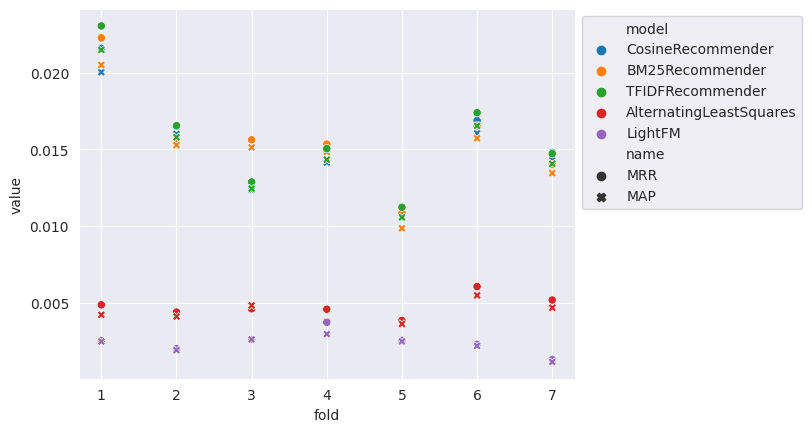

In [94]:
ax = sns.scatterplot(cross_valid_res[cross_valid_res["name"].isin(["MAP", "MRR"])], x="fold", y="value", style="name", hue="model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))